# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
import pickle
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from math import ceil
from glob import glob

# -----------------------------------------------------------------
# Load data
def loadData(directory):
    training_file = directory + 'train.p'
    validation_file = directory + 'valid.p'
    testing_file = directory + 'test.p'

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    return train, valid, test

train, valid, test = loadData('traffic-signs-data/')
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of an traffic sign image.
image_shape = [X_train.shape[1], X_train.shape[2]]

# Number of unique classes/labels in the dataset.
n_classes = np.max(train['labels'] + 1)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

max=30982.5, min=1275.0, mean=7464.896728515625, std=5683.693205934292
0 startIndex=28966
max=32640.0, min=127.5, mean=15225.039794921875, std=10856.353876416957
1 startIndex=21930
max=9052.5, min=765.0, mean=3904.84521484375, std=851.5385435085237
2 startIndex=33697
max=32640.0, min=2932.5, mean=17185.3564453125, std=8303.112335471938
3 startIndex=22932


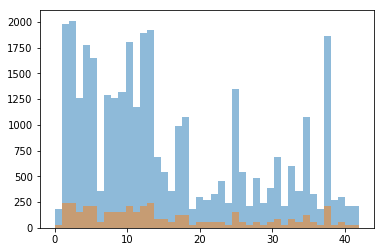

In [11]:
# Visualizations will be shown in the notebook.
%matplotlib inline

# =====================================================================================================
# DATA INSPECTION
# =====================================================================================================
# -----------------------------------------------------------------
# Normalize the pixel value to (-1,1)
#
# param    data        The data to be normalized
# param    inputMin     The minimum value of the input before normalization
# param    inputMax     The maximum value of the input before normalization
# param    outputMin    The minimum value of the output after normalization
# param    outputMax    The maximum value of the output after normalization
# returns               The normalized value
#
def minMaxNormalize(data, inputMin, inputMax, outputMin, outputMax):
    return outputMin + ((data - inputMin) * (outputMax - outputMin)) / (inputMax - inputMin)

# -----------------------------------------------------------------
# Display a grid of images
#
# param     imageSet        The set of all images to pull from
# param     indices         The indices of the images to display
# param     fileName        Name of the image to save
# param     numCols         The number of columns in the grid
# param     bNormalized     True if the imageset is normalized to (-1,1)
#
def displayImageGrid(imageSet, indices, fileName, numCols=10, bNormalized=True):
    numImages = len(indices)
    numRows = ceil(numImages/numCols)
    rows = []
    for i in range(numRows):
        imageRow = []
        for j in range(numCols):
            idx = i*numCols + j
            if (idx >= numImages):
                imageRow.append(np.zeros([32,32,1]))
            else:
                image = imageSet[indices[idx]]
                if bNormalized:
                    image = minMaxNormalize(image, -1., 1., 0., 255.)
                imageRow.append(image)
        rows.append(np.hstack(imageRow))

    output = np.vstack(rows)
    cv2.imwrite('visualization/' + fileName, output)
    cv2.imshow(fileName, output)

# -----------------------------------------------------------------
# Visualize the dataSet
#
# param     bDataDist               Create a histogram of the data set distribution
# param     bRandomImage            Display a randomImage
# param     bCompareProcessing      Compare the source image to the processed images
#
def inspectData(bDataDist=False, bRandomImage=False, bCompareProcessing=False):
    train, valid, test = loadData('traffic-signs-data/')
    if bDataDist:
        # plot the number of images in each class
        plt.hist(train['labels'], 43, alpha=0.5, label='train')
        plt.hist(valid['labels'], 43, alpha=0.5, label='valid')
        plt.savefig('visualization/histogram.png')
    if bRandomImage:
        randomImage = train['features'][np.random.randint(0, train['features'].shape[0])]
        plt.imsave('visualization/randomImage.png', randomImage)
    if bCompareProcessing:
        pretrain, pvalid, ptest = loadData('preprocess/')
        numCols = 10
        numRows = 4
        orig_rows = []
        proc_rows = []
        for i in range(numRows):
            startIndex = np.random.randint(0, pretrain['features'].shape[0])
            orig_rows.append(np.hstack(train['features'][startIndex:startIndex+numCols]))

            pImages = minMaxNormalize(pretrain['features'][startIndex:startIndex+numCols], -1., 1., 0., 255.)
            print('max={}, min={}, mean={}, std={}'.format(np.max(pImages), np.min(pImages),
                                                           np.mean(pImages), np.std(pImages)))
            proc_rows.append(np.hstack(pImages))
            print("{} startIndex={}".format(i, startIndex))

        orig = np.vstack(orig_rows)
        proc = np.vstack(proc_rows)
        cv2.imwrite('visualization/orig.png', orig)
        cv2.imwrite('visualization/proc.png', proc)
        
inspectData(bDataDist=True, bRandomImage=True, bCompareProcessing=True)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [13]:
# =====================================================================================================
# DATA PREPROCESSING
# =====================================================================================================

# -----------------------------------------------------------------
# Convert the image to grayscale
#
# param    img      The img to convert
# param    bPlot    True, to plot the image
# returns           The grayscaled image
#
def grayscale(img, bPlot=False):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if (bPlot):
        plt.imshow(gray, cmap='gray')
    return gray

# -----------------------------------------------------------------
# Apply Canny Edge Transform
#
# param    img              The img to convert
# param    low_threshold    Low value threshold to include
# returns  high_threshold   High value threshold to include
#
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# -----------------------------------------------------------------
# Preprocess a single image and return the result
#
def preprocessImage(image):
    # make sure the image is 32x32
    scaleFactorY = 32. / image.shape[0]
    scaleFactorX = 32. / image.shape[1]
    resized = cv2.resize(image, None, fx=scaleFactorX, fy=scaleFactorY, interpolation=cv2.INTER_AREA)
    gray = grayscale(resized)
    equ = cv2.equalizeHist(gray).reshape(32,32,1)
    normalized = minMaxNormalize(equ, 0., 255., -1., 1.)
    return normalized

# -----------------------------------------------------------------
# Preprocess a set of images
# First grayscale
# apply histogram equalization
# Then normalize the pixel values between (-1, 1)
#
# param     data            The data to be preprocessed
# param     outfileName     The name of the file to save the processed data to
# return                    The processed data
def preprocessImages(data, outfileName=''):
    X, y = data['features'], data['labels']
    newX = np.empty([X.shape[0], X.shape[1], X.shape[2], 1])

    # Convert all of the images to grayscale
    for i, img in enumerate(X):
        gray = grayscale(img)
        equ = cv2.equalizeHist(gray).reshape(32,32,1)
        newX[i] = equ

    # Normalize the images between (-1, 1)
    newX = minMaxNormalize(newX, 0., 255., -1., 1.)

    newData = {'features': newX, 'labels': y}

    # Save the processed data to disk
    if (len(outfileName) > 0):
        pickle.dump(newData, open("preprocess/" + outfileName, "wb"))

    return newData

# Rotate an image randomly
#
# param    img            The image to rotate
# param    maxRotation    The maximum allowed rotation
# returns                 The rotated image
def rotateRandom(img, maxRotation):
    rows = img.shape[0]
    cols = img.shape[1]
    rotation = np.random.rand() * 2 * maxRotation - maxRotation
    # print("rotation={}".format(rotation))
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation, 1)
    dst = cv2.warpAffine(img, M, (cols, rows))
    return dst

# Add a random amount of brightness to the image
#
# param     img             The image to brighten
# param     maxBrightness   The maxmimum amount of brightness to apply
# returns                   The brightened image
#
def brighten(img, maxBrightness):
    tempImg = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    tempImg.astype(dtype=np.float64)
    brightnessValue = np.random.rand() * maxBrightness
    tempImg[:,:,2] = tempImg[:,:,2]*brightnessValue
    # Clamp to no bigger than 255
    tempImg[:,:,2][tempImg[:,:,2]>255] = 255
    tempImg.astype(dtype=np.uint8)
    return cv2.cvtColor(tempImg,cv2.COLOR_HSV2RGB)

# Augment the training set to add more variation
#
# param     features      The training set of features to be augmented
# returns                 The augmented set
#
def augmentData(features):
    for i, feature in enumerate(features):
        feature = rotateRandom(feature, 30)
        feature = brighten(feature, .5)
        features[i] = feature
    return features

# ---------------------------------------------------------------------
# Given train, validation and test datasets
# Combine them into one set
# Shuffle them randomly
# And split back into train, validation and test sets
#
def combineAndSplit(train, valid, test):
    # Combine
    totalFeatures = np.concatenate([train['features'], valid['features'], test['features']])
    totalLabels = np.concatenate([train['labels'], valid['labels'], test['labels']])

    # Shuffle
    randFeatures, randLabels = shuffle(totalFeatures, totalLabels)

    # Split

    # test 60%
    dataSetSize = len(randFeatures)
    print("dataSetSize={}".format(dataSetSize))
    trainStartIdx = 0
    trainEndIdx = round(dataSetSize * .6)
    newTrainFeatures = randFeatures[trainStartIdx:trainEndIdx]
    newTrainLabels = randLabels[trainStartIdx:trainEndIdx]
    newTrain = {'features': newTrainFeatures, 'labels': newTrainLabels}
    print('trainStart:{} trainEnd:{} trainSize={}'.format(trainStartIdx, trainEndIdx, len(newTrainFeatures)))

    # Valid 20%
    validStartIdx = trainEndIdx + 1
    validEndIdx = validStartIdx + round(dataSetSize * .2)
    newValidFeatures = randFeatures[validStartIdx:validEndIdx]
    newValidLabels = randLabels[validStartIdx:validEndIdx]
    newValid = {'features': newValidFeatures, 'labels': newValidLabels}
    print('validStart:{} validEnd:{} validSize={}'.format(validStartIdx, validEndIdx, len(newValidFeatures)))

    # Test 20%
    testStartIdx = validEndIdx + 1
    testEndIdx = dataSetSize - 1
    newTestFeatures = randFeatures[testStartIdx:testEndIdx]
    newTestLabels = randLabels[testStartIdx:testEndIdx]
    newTest = {'features': newTestFeatures, 'labels': newTestLabels}
    print('testStart:{} testEnd:{} testSize={}'.format(testStartIdx, testEndIdx, len(newTestFeatures)))

    return newTrain, newValid, newTest

# ---------------------------------------------------------------------
# Preprocess the original data set
#
def preprocessData():
    ptrain, pvalid, ptest = loadData('traffic-signs-data/')
    ntrain, nvalid, ntest = combineAndSplit(ptrain, pvalid, ptest)
    # ptrain['features'] = augmentData(ptrain['features'])
    print("Preprocessing training set")
    preprocessImages(ntrain, 'train.p')
    print("Preprocessing validation set")
    preprocessImages(nvalid, 'valid.p')
    print("Preprocessing test set")
    preprocessImages(ntest, 'test.p')
    print("Preprocessing completed")
    
preprocessData()

dataSetSize=51839
trainStart:0 trainEnd:31103 trainSize=31103
validStart:31104 validEnd:41472 validSize=10368
testStart:41473 testEnd:51838 testSize=10365
Preprocessing training set
Preprocessing validation set
Preprocessing test set
Preprocessing completed


### Model Architecture

In [16]:
# =====================================================================================================
# NEURAL NETWORK
# =====================================================================================================


# Create a 2d convolutional layer
#
# inTensor  : input tensor to this layer
# shape     : shape of the layer
# stride    : integer value that determines how far to stride each iteration
# padding   : string either 'VALID' or 'SAME'
# mean      : mean value for random variable initialization
# stddev    : standard deviation value for random variable initialization
# name      : name of the layer
#
def conv2d(inTensor, weights, bias, stride, padding, name):
    return tf.nn.conv2d(inTensor, weights, strides=[1, stride, stride, 1], padding=padding, name=name) + bias

# Create a relu layer
#
# inTensor  : input tensor to this layer
#
def relu(inTensor, name):
    return tf.nn.relu(inTensor, name=name)

# Create a tanh layer
#
# inTensor  : input tensor to this layer
#
def tanh(inTensor):
    return tf.nn.tanh(inTensor)

# Create a sigmoid layer
#
# inTensor  : input tensor to this layer
#
def sigmoid(inTensor):
    return tf.nn.sigmoid(inTensor)

# Create a max pooling layer
#
# inTensor  : input tensor to this layer
# ksize     : size of the pooling layer
# stride    : integer value that determines how far to stride each iteration
# padding   : string either 'VALID' or 'SAME'
#
def maxPool(inTensor, ksize, stride, padding):
    return tf.nn.max_pool(inTensor, ksize=ksize, strides=[1, stride, stride, 1], padding=padding)

# Flatten a tensor
#
# inTensor  : input tensor to this layer
#
def flat(inTensor):
    return flatten(inTensor)

# Create a fully connected layer
#
# inTensor  : input tensor to this layer
# shape     : shape of the layer
# mean      : mean value for random variable initialization
# stddev    : standard deviation value for random variable initialization
#
def fullyConnected(inTensor, weights, bias):
    return tf.matmul(inTensor, weights) + bias

# Create a dropout layer
#
# inTensor  : input tensor to this layer
# dropout   : value to dropout
#
def dropout(inTensor, dropout):
    return tf.nn.dropout(inTensor, dropout)

def constructNetwork(x, y, keep_prob, regScalar, learningRate=0.001):
    # ----------------------------------------------------------------------------------
    # Construct the network
    # network = constructNetwork(x, DanNet())
    one_hot_y = tf.one_hot(y, n_classes)
    mu = 0
    sigma = 0.01
    # seed the rng to reduce the variation while testing different hyperparameters
    # tf.set_random_seed(1234)

    weights = {'conv1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean=mu, stddev=sigma)),
               'conv2': tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean=mu, stddev=sigma)),
               'conv3': tf.Variable(tf.truncated_normal(shape=(1, 1, 32, 16), mean=mu, stddev=sigma)),
               'fc1': tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma)),
               # 'fc4': tf.Variable(tf.truncated_normal(shape=(250, 120), mean=mu, stddev=sigma)),
               'fc2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma)),
               'fc3': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean=mu, stddev=sigma))}
    biases = {'conv1': tf.Variable(tf.zeros(16)),
              'conv2': tf.Variable(tf.zeros(32)),
              'conv3': tf.Variable(tf.zeros(16)),
              'fc1': tf.Variable(tf.zeros(120)),
              # 'fc4': tf.Variable(tf.zeros(120)),
              'fc2': tf.Variable(tf.zeros(84)),
              'fc3': tf.Variable(tf.zeros(n_classes))}
    # ----------------------------------------------------------------------------------------------------------
    # Feature Extraction
    # Convolution -> MaxPool -> Convolution -> MaxPool
    #
    network = conv2d(x, weights['conv1'], biases['conv1'], 1, 'VALID', 'conv1')  # 28x28x16
    network = relu(network, 'activate1')
    network = maxPool(network, (1, 2, 2, 1), 2, 'VALID')  # 14x14x16
    network = dropout(network, keep_prob)

    network = conv2d(network, weights['conv2'], biases['conv2'], 1, 'VALID', 'conv2')  # 10x10x32
    network = relu(network, 'activate2')
    network = maxPool(network, (1, 2, 2, 1), 2, 'VALID')  # 5x5x32
    network = dropout(network, keep_prob)

    network = conv2d(network, weights['conv3'], biases['conv3'], 1, 'VALID', 'conv3')  # 5x5x16
    network = relu(network, 'activate3')

    # network = conv2d(network, weights['conv3'], biases['conv3'], 1, 'VALID')    # 5x5x16
    # network = dropout(network, keep_prob)

    # ----------------------------------------------------------------------------------------------------------
    # Classifier
    # Flattened Extracted Features -> Fully Connected -> Fully Connected -> Fully Connected (Classifier)
    #
    network = flat(network)  # 400x1
    network = fullyConnected(network, weights['fc1'], biases['fc1'])  # 400x300
    network = relu(network, 'activatefc1')
    # network = fullyConnected(network, weights['fc4'], biases['fc4'])           # 300x120
    # network = relu(network)
    network = fullyConnected(network, weights['fc2'], biases['fc2'])  # 120x84
    network = relu(network, 'activatefc2')
    network = dropout(network, keep_prob)
    network = fullyConnected(network, weights['fc3'], biases['fc3'])  # 84x43
    # ----------------------------------------------------------------------------------

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=network, labels=one_hot_y, name='cross_entropy')

    # Apply l2 regularization to the weights
    # to help prevent overfitting
    regularization_term = 0
    for key, value in weights.items():
        regularization_term = regScalar * tf.nn.l2_loss(value)

    loss_operation = tf.reduce_mean(cross_entropy + regularization_term)

    optimizer = tf.train.AdamOptimizer(learning_rate=learningRate)
    trainer = optimizer.minimize(loss_operation, name='trainer')

    prediction = tf.argmax(network, 1, name='prediction')
    correct_answer = tf.argmax(one_hot_y, 1, name='correct_answer')
    correct_prediction = tf.equal(prediction, correct_answer, name='correct_prediction')
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy_operation')

    return network

# -----------------------------------------------------------------
# Globals
dropOutProb = 0.5
regScalarValue = 0.01
epochs = 10  
batchSize = 128  
learningRate = 0.001

# -----------------------------------------------------------------------------
# Execute code here
ptrain, pvalid, ptest = loadData('preprocess/')
X_trainp, y_trainp = ptrain['features'], ptrain['labels']
X_validp, y_validp = pvalid['features'], pvalid['labels']
X_testp, y_testp = ptest['features'], ptest['labels']
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
regScalar = tf.placeholder(tf.float32)
network = constructNetwork(x, y, keep_prob, regScalar, learningRate)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [18]:
# --------------------------------------------------------------------------------------------------------
# Calculate the accuracy of the model
#
def evaluate(X_data, y_data, accuracy_operation, x, y, keep_prob, regScalar, batchSize):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batchSize):
        batch_x, batch_y = X_data[offset:offset+batchSize], y_data[offset:offset+batchSize]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, regScalar: 0.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# -----------------------------------------------------------------
# Train a neural net
#
def trainNetwork(epochs, batchSize, learningRate):
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        trainer = sess.graph.get_operation_by_name('trainer')
        accuracy_operation = sess.graph.get_tensor_by_name('accuracy_operation:0')

        num_examples = len(X_trainp)
        print("Training...")
        print("Params: epochs:{}\tbatchSize:{}\tlearningRate:{}".format(epochs, batchSize, learningRate))
        print()
        train_plot = []
        valid_plot = []
        test_plot = []
        train_accuracy = 0.
        validation_accuracy = 0.
        test_accuracy = 0.
        for i in range(epochs):
            X_train_shuffle, y_train_shuffle = shuffle(X_trainp, y_trainp)
            for offset in range(0, num_examples, batchSize):
                end = offset + batchSize
                batch_x, batch_y = X_train_shuffle[offset:end], y_train_shuffle[offset:end]
                sess.run(trainer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropOutProb, regScalar: regScalarValue})

            # Calculate accuracy at this point
            # on the training set
            # and the validation set
            train_accuracy = evaluate(X_trainp, y_trainp, accuracy_operation, x, y, keep_prob, regScalar, batchSize)
            train_plot.append(train_accuracy)
            validation_accuracy = evaluate(X_validp, y_validp, accuracy_operation, x, y, keep_prob, regScalar, batchSize)
            valid_plot.append(validation_accuracy)
            test_accuracy = evaluate(X_testp, y_testp, accuracy_operation, x, y, keep_prob, regScalar, batchSize)
            test_plot.append(test_accuracy)
            print("EPOCH {} ...".format(i + 1))
            print("Accuracy Training = {:.3f}  Validation = {:.3f}  Test = {:.3f}\n".format(train_accuracy, validation_accuracy, test_accuracy))

        # Generate the learning curve plot
        x_axis = np.arange(0, epochs, 1)
        fig, ax = plt.subplots(1)
        ax.plot(x_axis, train_plot, lw=2, label='train', color='blue')
        ax.plot(x_axis, valid_plot, lw=1, label='valid', color='red', ls='--')
        ax.plot(x_axis, valid_plot, lw=1, label='test', color='green', ls='--')
        ax.legend(loc='upper left')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Accuracy')
        plt.title("Params: epochs:{}    batchSize:{}    learningRate:{}".format(epochs, batchSize, learningRate))
        ax.text(0.95, 0.01, "train:{:.3f}   valid:{:.3f}   test:{:.3f}".format(train_accuracy, validation_accuracy, test_accuracy),
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes,
                color='green', fontsize=15)
        pltFileName = 'visualization/plots/Accuracy.png'
        plt.savefig(pltFileName)
        print("Plot saved in {}".format(pltFileName))

        # Save the model
        saver.save(sess, 'models/lenet')
        print("Model saved")


trainNetwork(epochs, batchSize, learningRate)

Training...
Params: epochs:10	batchSize:128	learningRate:0.001



InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder', defined at:
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-cfe2028007c3>", line 168, in <module>
    x = tf.placeholder(tf.float32, (None, 32, 32, 1))
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1587, in placeholder
    name=name)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2043, in _placeholder
    name=name)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/sarvagyagupta1/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [7]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# =====================================================================================================
# PREDICTION
# =====================================================================================================
# ----------------------------------------------------------------
# Load and return the test images
#
def loadTestImages():
    fileNames = glob('testImages/*.png')
    fileNames.sort()

    images = []
    for fileName in fileNames:
        print("fileName= {}".format(fileName))
        imageName = fileName[:-3]
        img = cv2.imread(fileName)
        images.append(img)
    return images

# ----------------------------------------------------------------
# Given a set of images
# Classify them
#
def classifyImages(images, labels):

    # Preprocess the images
    processedImages = []
    for image in images:
        processedImages.append(preprocessImage(image))

    displayImageGrid(processedImages, np.arange(0, len(images)), "testImages.png", len(images))

    saver = tf.train.Saver();
    with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
        saver.restore(sess, 'models/lenet')
        prediction = sess.graph.get_tensor_by_name('prediction:0')
        correct_answer = sess.graph.get_tensor_by_name('correct_answer:0')
        correct_prediction = sess.graph.get_tensor_by_name('correct_prediction:0')
        accuracy_operation = sess.graph.get_tensor_by_name('accuracy_operation:0')

        pred = sess.run(prediction, feed_dict={x: processedImages, y:labels, keep_prob: 1.0, regScalar: 0.0})
        #print("Predictions:{}".format(pred))
        answer = sess.run(correct_answer, feed_dict={y: labels, keep_prob: 1.0, regScalar: 0.0})
        #print("Answers:{}".format(answer))
        correct = sess.run(correct_prediction,
                           feed_dict={x: processedImages, y: labels, keep_prob: 1.0, regScalar: 0})
        #print("Correct:{}".format(correct))
        accuracy = sess.run(accuracy_operation,
                            feed_dict={x: processedImages, y: labels, keep_prob: 1.0, regScalar: 0.0})
        #print("Accuracy: {:.0f}%".format(accuracy * 100.))
        softmax = sess.run(tf.nn.top_k(tf.nn.softmax(network), k=5),
                           feed_dict={x: processedImages, y: labels, keep_prob: 1.0, regScalar: 0.0})
        #print("Softmax: {}".format(softmax))
        return pred, accuracy, softmax

### Predict the Sign Type for Each Image

In [8]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
pred, accuracy, softmax = classifyImages(loadTestImages(), [29, 28, 38, 17,13])
print("Predictions:{}".format(pred))

fileName= testImages/bike.png
fileName= testImages/childrenCrossing.png
fileName= testImages/keepRight.png
fileName= testImages/noEntry.png
fileName= testImages/yield.png
Predictions:[12 34 32 31 13]


### Analyze Performance

In [9]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
# pred, accuracy, softmax = classifyImages(loadTestImages(), [3, 1, 14, 27, 13])
print("Accuracy: {:.0f}%".format(accuracy * 100.))

Accuracy: 20%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [10]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
# pred, accuracy, softmax = classifyImages(loadTestImages(), [3, 1, 14, 27, 13])
print("Softmax: {}".format(softmax))

Softmax: TopKV2(values=array([[  4.90283012e-01,   3.20957035e-01,   1.70503899e-01,
          5.65979537e-03,   4.49624145e-03],
       [  9.97328758e-01,   1.37547299e-03,   4.77697060e-04,
          4.16335621e-04,   3.71784699e-04],
       [  2.50656933e-01,   1.75195128e-01,   1.33379862e-01,
          1.25588819e-01,   7.85648227e-02],
       [  2.87274987e-01,   2.44165152e-01,   6.45578578e-02,
          5.19448705e-02,   4.26192544e-02],
       [  9.89703834e-01,   5.95089886e-03,   4.27805306e-03,
          5.61258203e-05,   3.36155881e-06]], dtype=float32), indices=array([[12, 17, 14, 33, 15],
       [34, 35, 38, 30, 20],
       [32, 18, 11, 28, 12],
       [31, 20, 30, 23, 10],
       [13, 12, 14,  1,  4]], dtype=int32))


# Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p>

FeatureMaps saved in visualization/featureMaps/activate1:0.png


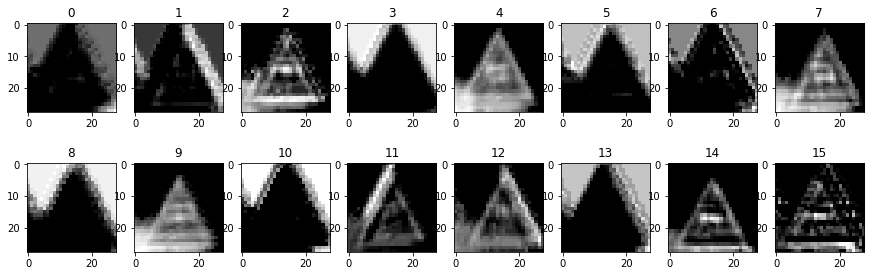

In [11]:
# ------------------------------------------------------------------------------------------
# Outputs the feature maps for a particular image
#
# param     image           The image to get feature maps for
# param     featureMaps     Array of feature maps to get
#
def outputFeatureMap(image, featureMaps, activation_min=-1, activation_max=-1, plt_num=1):

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        plt.imsave('visualization/featureMaps/featureMapOrig.png', image.reshape(32, 32))
        for featureName in featureMaps:
            tf_activation = sess.graph.get_tensor_by_name(featureName)
            activation = tf_activation.eval(session=sess, feed_dict={x: [image], keep_prob: dropOutProb,
                                                                     regScalar: regScalarValue})
            featuremaps = activation.shape[-1]
            plt.figure(plt_num, figsize=(15, 15))
            for featuremap in range(featuremaps):
                plt.subplot(6, 8, featuremap + 1)  # sets the number of feature maps to show on each row and column
                plt.title('' + str(featuremap))  # displays the feature map number
                if activation_min != -1 & activation_max != -1:
                    plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmin=activation_min,
                               vmax=activation_max, cmap="gray")
                elif activation_max != -1:
                    plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmax=activation_max,
                               cmap="gray")
                elif activation_min != -1:
                    plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", vmin=activation_min,
                               cmap="gray")
                else:
                    plt.imshow(activation[0, :, :, featuremap], interpolation="nearest", cmap="gray")
            featureMapsFileName = 'visualization/featureMaps/' + featureName + '.png'
            plt.savefig(featureMapsFileName)
            print("FeatureMaps saved in {}".format(featureMapsFileName))


# -----------------------------------------------------------------
# Evaluate the missed classifications
#
def evaluateMisses(testData):
    features, labels = testData['features'], testData['labels']

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        prediction = sess.graph.get_tensor_by_name('prediction:0')
        correct_answer = sess.graph.get_tensor_by_name('correct_answer:0')
        correct_prediction = sess.graph.get_tensor_by_name('correct_prediction:0')
        pred = sess.run(prediction, feed_dict={x: features, keep_prob: 1.0, regScalar: 0.0})
        answer = sess.run(correct_answer, feed_dict={y: labels, keep_prob: 1.0, regScalar: 0.0})
        correct = sess.run(correct_prediction, feed_dict={x:features, y:labels, keep_prob:1.0, regScalar:0})
        incorrectIndices = np.where(correct == False)[0]
        # print("Prediction:{} Answer:{}".format(pred, answer))
        print("Num Incorrect:{}/{}".format(incorrectIndices.shape, features.shape[0]))
        print("predictions:{}".format(pred[incorrectIndices]))
        print("=====================================================")
        print("answers:{}".format(answer[incorrectIndices]))
        print("=====================================================")
        print("indices:{}".format(incorrectIndices))

        displayImageGrid(features, incorrectIndices, 'incorrectPredictions.png', numCols=12)
        
# evaluateMisses(validData)
outputFeatureMap(X_trainp[0], featureMaps=['activate1:0'])#, 'activate2:0', 'activate3:0'])

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


I noticed in the first convolution layer that the feature map displayed the mostly the edges of the signs. It closely resembled the the shape of the sign. In the later convolutional layers the feature maps displayed more focused features. For example for the "end of no passing" sign you could clearly see a diagonal slash feature represented. Along with some curved edges.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 